In [363]:
import numpy as np
import pandas as pd

from datetime import * #On est amené à gérer des dates avec departure et arrival
import mpu #calcul de la distance harvesine pour convertir deux latitudes et longitudes en distance kilométrique

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Création des Dataframmes initaux

df_ticket_init=pd.read_csv('data/ticket_data.csv')
df_cities_init=pd.read_csv('data/cities.csv')
df_stations_init=pd.read_csv('data/stations.csv')
df_providers_init=pd.read_csv('data/providers.csv')

df_ticket_init
df_ticket_1# version du dataframme sans le gtm qui est, dans mon cas, inutilement complexe à convertir
df_ticket_2# version avec le temps de voyage calculé en minutes à partir des departures et arrival modifiés de df_ticket_1
df_ticket_3# version avec la distance du voyage en km

df_providers_1#La colonne id a été renommée compagnypour matcher avec df_ticket_4

df_cities_1 #créer pour un affichage avec altair, exempté de ce que j'interprête comme des valeurs extrêmes nuisant à la bonne lecture du reste des données, cependant rien ne justifie de les supprimer réellement.

In [407]:
df_ticket_init

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542
...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,13,279.0,10729.0,2017-10-27 02:30:00+00,2017-10-27 16:00:00+00,2590,2017-10-19 10:35:42.943+00,"{408,408}",{8371},628,562
74164,6869185,9,279.0,304.0,2017-10-27 07:00:00+00,2017-10-27 13:30:00+00,2700,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74165,6869187,8371,10642.0,304.0,2017-10-27 08:30:00+00,2017-10-27 15:15:00+00,3000,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74166,6869189,13,279.0,304.0,2017-10-27 13:25:00+00,2017-10-27 21:10:00+00,2880,2017-10-19 10:35:42.943+00,"{863,863}",{13},628,562


Je comprends ici que certaines observations peuvent valoir NaN sans problèmes tandis que d'autres sont "indispensables" donc probablement à écarter pour des traitement suplémentaires. En temps normal il faudrait vérifier chacunes des colones avec un algorithme visant à reprérer les valeurs extrêmes et abérrantes afin de les traiter. Je n'ai malheureusemet pas eux letemps de le faire.

Voici les colonnes qui me sembles "indispensables" (qui ne devraient pas posséder de valeurs NaN, sauf erreur):

'id', 'company', 'o_station', 'd_station', 'departure_ts', 'arrival_ts','price_in_cents', 'search_ts','o_city', 'd_city'

Et celles qui ne posent pas problèmes lorsqu'elles en ont:

'middle_stations' 
(peut être entre un trajet direct)

'other_companies'
(Le trajet peut être effectué avec une seule et même compagnie)

Ici pour df_stations_init comme pour v df_cities_init, toutes les colonnes me sembles "indispensables" donc aucunes ne devrait être initialisée à NaN.

On constate que pour la valeur population de df_cities_init, il faudrait pouvoir croiser les données avec d'autres sources.

In [368]:
df_cities_init

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN
...,...,...,...,...,...,...
8035,9964,"Saint-André-lez-Lille, Hauts-de-France, France",saint-andre-lez-lille,50.654250,3.047690,NaN
8036,10863,"Kiev, Шевченківський район, Ukraine",kiev,50.450100,30.523400,NaN
8037,11144,"Brighton, England, UK",brighton,50.822000,-0.137400,NaN
8038,11377,"Manises, Comunitat Valenciana, España",manises,39.493000,-0.462100,NaN


In [10]:
df_stations_init

,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737
...,...,...,...,...
11030,11032,Porto Avda De Los Aliados,41.146922,-8.611122
11031,11033,Rom Ciampino Flughafen Piazzale Leonardo da Vinci,41.804102,12.597110
11032,11034,Sants,41.379892,2.139462
11033,11035,Vozilici D66,45.157136,14.164140


Voici, pour providers, les colonnes qui me sembles "indispensables" (qui ne devraient pas posséder de valeurs NaN, sauf erreur):

'id', 'company_id', 'name', 'fullname', 'has_wifi', 'has_plug', 'has_adjustable_seats', 'has_bicycle', 'transport_type'

Et celles qui ne posent pas problèmes lorsqu'elles en ont:

'provider_id'
(Ce n'est pas parce que c'est une branche d'une plus grosse société qu'elle doit avoir un nom,sauf preuve du contraire)

Ici donc, à l'exception de provider_id, toutes les colonnes me sembles "indispensables", spécialement les colones de type booléene dont le NaN me semble abérrant.

In [409]:
df_providers_init

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus
...,...,...,...,...,...,...,...,...,...,...
222,8384,10,16,thalys,Thalys,True,True,False,True,train
223,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
224,8387,30,NaN,vatry,Vatry,NaN,NaN,NaN,NaN,bus
225,8388,40,NaN,beauval,Beauval,NaN,NaN,NaN,NaN,bus


In [418]:
print(df_providers_init.company_id.value_counts())

9     201
10     11
20      4
1       1
2       1
3       1
4       1
5       1
6       1
8       1
11      1
12      1
30      1
40      1
Name: company_id, dtype: int64


Petite curiosité du nombre de company différentes présentes dans le dataset, la numéro 9 est donc l'élément le plus important de ce dataset.

On notera sur tous ces dataframes les valeurs id qui soulignent un lien direct en eux, représentable par du génie logiciel. Schéma imaginé mais non fait.

Commençons maintenant par le premier exercice:

Extraire les infos intéressantes type prix min, moyen et max:
Cette question se traite visiblement seulement sur le dataframme df_ticket_init:

In [26]:
prix_moyen = df_ticket_init.price_in_cents.describe()['50%']#Je choisi ici la valeur la représentative de 50% de notre dataset plutôt que la moyenne classique car elle est plus représentative des réelles trandsactions.En effet, siun client acchète pour extremement cher cela ne change pour autant pas les habitudes des autres clients et donc porrait initier un biais. Par ailleurs il est impossible ici de payer la valeur moyenne alorsquelle devrait être la plus représentative. Mais si ce choix ne parait pasconvenable, il suffit de remplacer le '50%' par 'mean'
prix_min = df_ticket_init.price_in_cents.describe()['min']
prix_max = df_ticket_init.price_in_cents.describe()['max']


count    74168.000000
mean      4382.711061
std       3739.325367
min        300.000000
25%       1900.000000
50%       3350.000000
75%       5250.000000
max      38550.000000
Name: price_in_cents, dtype: float64

Extraire les infos intéressantes type durée min/max/moyenne par trajet:
Pour cela je vais convertir les caracteristiques departure_ts et arrival_ts en secondes.

Je commence par modifier les valeurs de departure et arrival,
en effet avec leur terminaison ':00' je ne pouvait les traiter correctement.

Je précise bien comprendre qu'il s'agisse de l'heure GMT (puisqu'Orléans par exemple possède +00 alors q'il devrait posséder +02 avec l'heure UTC). 

Cependant cet aspect de l'information ne nous sera pas utile pour résoudre la question de l'exercice.

In [ ]:
df_ticket_1=df_ticket_init.copy()#Une copy pour ne pas avoir à relancer inutilement d'autres cellules en testant.
for n in range(len(df_ticket_1)):
        df_ticket_1.arrival_ts.loc[n]=(df_ticket_1.arrival_ts.loc[n])[0:-3]
        df_ticket_1.departure_ts.loc[n]=(df_ticket_1.departure_ts.loc[n])[0:-3]

df_ticket_1

In [98]:
df_ticket_2=df_ticket_1.copy()

In [ ]:
df_ticket_2['time_travel_min']=0# représentation du temps passé en minute pour le trajet ( si toutefois aucune catastrophe type apocalype ou attaque alien ne vient le perturber,les retards étant évidement du même accabit...)
#time_travel_min est également initialisée à 0 pour créer une variable numérique dans le dataframe.

for n in range(len(df_ticket_2)):
        #print(n)Pour patienter le temps du calcul, ça prouve aussi que je devrais l'optimiser si j'y passait plus de temps.
        #Donc ci dessous on remplace la valeur 0 par la soustraction de departure à arrival, le tout arrive en secondes et je le converti en minutes.
        df_ticket_2.time_travel_min.loc[n]=(datetime.strptime(df_ticket_2.arrival_ts.loc[n], "%Y-%m-%d %H:%M:%S")-datetime.strptime(df_ticket_2.departure_ts.loc[n], "%Y-%m-%d %H:%M:%S")).total_seconds()/60

In [101]:
df_ticket_2

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,time_travel_min
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00,2017-10-13 20:10:00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,370.0
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00,2017-10-14 06:55:00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,1070.0
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00,2017-10-14 21:24:00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,1917.0
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00,2017-10-14 11:02:00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,1295.0
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00,2017-10-14 19:32:00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,1306.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,13,279.0,10729.0,2017-10-27 02:30:00,2017-10-27 16:00:00,2590,2017-10-19 10:35:42.943+00,"{408,408}",{8371},628,562,810.0
74164,6869185,9,279.0,304.0,2017-10-27 07:00:00,2017-10-27 13:30:00,2700,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562,390.0
74165,6869187,8371,10642.0,304.0,2017-10-27 08:30:00,2017-10-27 15:15:00,3000,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562,405.0
74166,6869189,13,279.0,304.0,2017-10-27 13:25:00,2017-10-27 21:10:00,2880,2017-10-19 10:35:42.943+00,"{863,863}",{13},628,562,465.0


In [106]:
df_ticket_2.describe()

,id,company,o_station,d_station,price_in_cents,o_city,d_city,time_travel_min
count,7.416800e+04,74168.000000,32727.000000,32727.000000,74168.000000,74168.000000,74168.000000,74168.000000
mean,6.832108e+06,7109.565527,2907.132673,2347.858129,4382.711061,849.186105,883.776265,424.620793
std,2.141060e+04,3005.380792,3347.629180,3090.798007,3739.325367,1485.791782,1654.698575,594.981356
min,6.795025e+06,9.000000,3.000000,3.000000,300.000000,5.000000,1.000000,20.000000
25%,6.813567e+06,8376.000000,400.000000,396.000000,1900.000000,485.000000,453.000000,180.000000
50%,6.832108e+06,8385.000000,701.000000,575.000000,3350.000000,628.000000,562.000000,290.000000
75%,6.850650e+06,8385.000000,6246.000000,4538.000000,5250.000000,628.000000,628.000000,480.000000
max,6.869192e+06,8387.000000,11017.000000,11017.000000,38550.000000,12190.000000,12190.000000,29571.000000


In [108]:
duree_moy = df_ticket_2.time_travel_min.describe()['mean']#Je choisi ici la valeur la représentative de 50% de notre dataset plutôt que la moyenne classique car elle est plus représentative des réelles trandsactions.En effet, siun client acchète pour extremement cher cela ne change pour autant pas les habitudes des autres clients et donc porrait initier un biais. Par ailleurs il est impossible ici de payer la valeur moyenne alorsquelle devrait être la plus représentative. Mais si ce choix ne parait pasconvenable, il suffit de remplacer le '50%' par 'mean'
duree_min = df_ticket_2.time_travel_min.describe()['min']
duree_max = df_ticket_2.time_travel_min.describe()['max']

424.6207933340524 20.0 29571.0


Nous obtenons ainsi les valeurs recherchées.

Voici maintenant la différence de prix moyen par la durée selon le train, le bus et le covoit selon la distance du trajet 
(0-200km, 201-800km, 800-2000km, 2000+km) 
Je vais donc créer une matrice de 3 colonnes pour 4 lignes de graphiques afin de comparer lesprix par rapport à la distance
J'aurais pu tenter de donner une couleur différentes en fonction du moyen de transport et faire donc 3 fois moins de graphiques, mais leur superpositions aurait nuit à la lecture. Une amélioration possible aurait été de faire un graphique en 3D avec les changements de couleurs précités.

Voici maintenant la différence de prix moyen par la durée selon le train, le bus et le covoit selon la distance du trajet 
(0-200km, 201-800km, 800-2000km, 2000+km) 

In [262]:

#Fonction convertissant deux couples latitude et longitude en distance kilométrique.
def find_distance(o_city, d_city):
    
    o_lat=float(df_cities_init.query("id=="+str(o_city)).latitude)
    o_long=float(df_cities_init.query("id=="+str(o_city)).longitude)
    d_lat=float(df_cities_init.query("id=="+str(d_city)).latitude)
    d_long=float(df_cities_init.query("id=="+str(d_city)).longitude)
    
    position_1 = (o_lat, o_long)
    position_2 = (d_lat, d_long)
    return round(mpu.haversine_distance(position_1, position_2),2)# résultat arrondi à 2 chiffres
"""
#Ce n'est pas forcément la façon de faire la plus optimisée mais c'est la plus simple à mettreen place.
#Il est plus compliqué mais bien plus rapide pour la machine de retenir les couples (o_city, d_city) 
# pour ne pas recalculer sans arret la même distance.

#Mais l'amélioration possible de cet aprtie aurait été de le faire et d'ensuite repositionner les
# bonnes valeurs dans le dataframme, je laisse ici un début de l'algorithme pour le faire, je récupère dans
# une liste les couples uniques de lattitude et longitude du dataframe.

lst_od_city=[]
for n in range(len(df_ticket_2)):
    lst_od_city.append((df_ticket_2.loc[n].o_city,df_ticket_2.loc[n].d_city))
lst_od_city=list(set(lst_od_city))
"""

'lst_od_city=[]\nfor n in range(len(df_ticket_2)):\n    lst_od_city.append((df_ticket_2.loc[n].o_city,df_ticket_2.loc[n].d_city))\nlst_od_city=list(set(lst_od_city))\n'

In [ ]:
df_ticket_3=df_ticket_2.copy()
df_ticket_3['distance']=0.0 #même logique de précédement, je crée la colonne que j'initialise comme un float

#Voici maintenant le calcul et l'implémentation des distances des trajets dans le dataframe
for n in range(len(df_ticket_3)):
    #print(n) très optimisable, parallélisable même,le calcul ici est long!
    df_ticket_3.distance.loc[n]=find_distance(df_ticket_3.o_city.loc[n],df_ticket_3.d_city.loc[n])

Voici maintenant la différence de prix moyen par la durée selon le train, le bus et le covoit selon la distance du trajet 
(0-200km, 201-800km, 800-2000km, 2000+km) 

Petite prise de conscience en regardant le dataset cependant: Ce n'est pas parce que j'ai un id de company dans mes datafame qu'elle a déjà été utilisée pour des transactions du dataset, çà ce stade de l'exercice il me parait utile de le garder en tête.


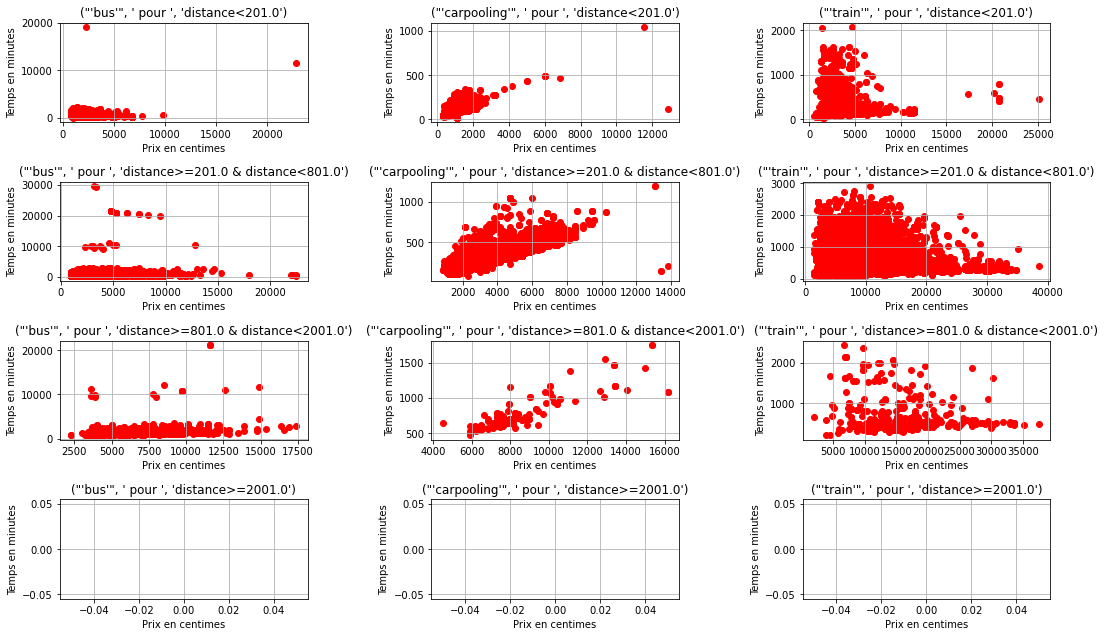

In [336]:
df_providers_1=df_providers_init.copy()
df_providers_1=df_providers_1.rename(columns = {'id': 'company'}) #pour faciliter le merge que je me prépare à faire.

#Le merge permeet d'augmenter la lisibilité du reste de mon code en simplifiant mes algorithmes j'y ait lisé les transactions aux company qui en ont bénéficier.
df_ticket_provider=pd.merge(df_ticket_3,df_providers_1,left_on='company',right_on='company',how="inner")

#Deux listes contenant les query que je vais faire, ça me paraît plus lisible de cette façon.
req_transports=["transport_type=='bus'","transport_type=='carpooling'","transport_type=='train'"]
req_distances=["distance<201.0","distance>=201.0 & distance<801.0","distance>=801.0 & distance<2001.0","distance>=2001.0"]

i=1#Pour signifier à matplotlib de quel graphique on parle  
plt.figure(1,figsize=(10,10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 1.5,top = 0.9, wspace = 0.5, hspace = 0.6)# lisibilité ++

for req_distance in req_distances: #on prends chaque requêtes parmis celles des distances
    for req_transport in req_transports:#on prends chaque requêtes parmis celles des transports
        
        plt.subplot(4,3,i)# le "i" ici est important, c'est le ième graphique de notre boucle
        
        #On récupère les parties du dataframme qui nous interessent selon le sconditions de nos requêtes.
        xaxis=df_ticket_provider.query(req_distance).query(req_transport).price_in_cents
        yaxis=df_ticket_provider.query(req_distance).query(req_transport).time_travel_min
        
        plt.scatter(xaxis,yaxis,color='r')
        plt.title((req_transport.replace("transport_type==","")," pour ",req_distance))# On précise le transport et la distance en titre
        plt.grid()
        plt.xlabel('Prix en centimes')
        plt.ylabel('Temps en minutes')
        i+=1

plt.show()

On remarque ici que de manière générale, les tempsdetrajets sont plus avantageux par covoiturages puis en bus puis en train, le prix suivant également cette tendance.

Je note également que le temps du covoiturage a tendance à plus fortement augmenter comparé au trains et bus, indiquant donc qu'il est peut-être plus interessant de ce fier aux bus ou aux trains si l'on est pressé (ce qui d'expérience se vérifie parfaitement...)

Enfin bien qu'en amélioration ce graphique mériterait probablement aussi un affichage de ladensité (en assombrissant lespoints qui se superposent) il semble qu'une très grande diversité de choix soit proposé par les voyages en train par rapport aux bus et au covoiturage. Notons également notre manque de données pour conclure quoi que ce soit en terme de très grandes distances.



In [378]:
#Petit bonus, une idée m'ayant traversée avec les lattitudes et les longitudes:
#Est-il possible de les afficher sur un axe et d'y' voir apparaitre notre influcence géographique?
import altair as alt 
alt.data_transformers.enable('json') # Pour qu'Altair gère les grands datasets

8040

Nous voyons ici que tictactrip s'implante un peu plus en europe avec sans doute quelques aéroports étrangers
C'est unpeu interactifs mais lemanques de données sur le spopulations se fait sentir, notement pour la densité des différents points.

In [405]:
map = alt.Chart(df_cities_init).mark_point(size=5).encode(
    x=alt.X('longitude:Q'),
    y=alt.Y('latitude:Q', scale=alt.Scale(zero=False)),
    tooltip=['unique_name:N','local_name:N','population:Q']
).properties(
    width=800,
    height=400
)


map

alt.Chart(...)

En enlevant les valeurs trop éloignées de l'europe on pourrait avoir un meilleur rendu visuel, cependant la curiosité me pousse à en aficher certaines, et il semble que quelques valeurs abbérantes puissent s'être glissées dans notre dataset (l'italie à coté de New Orléans?)

In [420]:
df_cities_init.query('longitude<-80')

,id,local_name,unique_name,latitude,longitude,population
8,11984,"Borger, Texas, United States of America",borger,35.667820,-101.397388,NaN
3382,1163,"Nola, Campania, Italia",nola,29.951066,-90.071532,NaN
4170,4911,"New Orleans, Louisiana, United States of America",new-orleans,29.951066,-90.071532,NaN


Voici donc un visuel plus lisible, emputé de ces valeurs extrêmes ou abérrantes, notons qu'une fusion des dataset providers et city aurait pu contribuer à une visualisation avec des couleurs et l'affichage des arrêts que nous possédons.

In [403]:
df_cities_1=df_cities_init.copy()
df_cities_1=df_cities_1.query('latitude>27').query('longitude>-25')

map = alt.Chart(df_cities_1).mark_point(size=5).encode(
    x=alt.X('longitude:Q'),
    y=alt.Y('latitude:Q', scale=alt.Scale(zero=False)),
    tooltip=['unique_name:N','local_name:N','population:Q']
).properties(
    width=500,
    height=400
)


map

alt.Chart(...)